In [34]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
train_df = pd.read_csv('bitcoin_price_Training - Training.csv')
test_df = pd.read_csv('bitcoin_price_1week_Test - Test.csv')

### Descrevendo as Colunas do Dataset

In [36]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1556 non-null   object 
 1   Open        1556 non-null   float64
 2   High        1556 non-null   float64
 3   Low         1556 non-null   float64
 4   Close       1556 non-null   float64
 5   Volume      1556 non-null   object 
 6   Market Cap  1556 non-null   object 
dtypes: float64(4), object(3)
memory usage: 85.2+ KB
None
              Open         High          Low        Close
count  1556.000000  1556.000000  1556.000000  1556.000000
mean    582.625328   597.992847   567.851446   584.239396
std     523.137312   542.992855   505.877401   525.904442
min      68.500000    74.560000    65.530000    68.430000
25%     254.287500   260.327500   248.835000   254.320000
50%     438.600000   447.560000   430.570000   438.855000
75%     662.437500   674.525000   646.735000   663.402500
max

### Escolhendo a coluna de interesse (preço de fechamento)

In [37]:
train_data = train_df['Close'].values.astype('float32')
test_data = test_df['Close'].values.astype('float32')

### Normalização dos dados

In [50]:
train_mean, train_std = train_data.mean(), train_data.std()
train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std
print (test_data)
print (train_data)

[5.315793  5.001947  5.0760713 4.3969846 4.22359   4.044678  4.059115 ]
[ 4.357897   4.1331444  4.074693  ... -0.8468887 -0.8363511 -0.8559997]


### Preparação dos dados para treinamento

In [53]:
def create_sequences(data, seq_length):
    print (len(data))
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    print (len(sequences), len(labels))
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
print(f"X_test shape: {X_test.shape}")

1556
1551 1551
7
2 2
X_test shape: torch.Size([2, 5])


### Redimensionar os dados para o formato esperado pela RNN

In [54]:
X_train = X_train.unsqueeze(-1)
X_test = X_test.unsqueeze(-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Definindo a RNN

In [55]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
      output, _ = self.rnn(x)
      output = self.linear(output[:, -1, :])
      return output
input_size = 1
hidden_size = 64
output_size = 1
net = RNNModel(input_size, hidden_size, output_size).to(device)

### Treinamento do modelo

In [56]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

num_epochs = 50
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = net(batch_x).squeeze()
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.0072
Epoch 20, Loss: 0.0164
Epoch 30, Loss: 0.0092
Epoch 40, Loss: 0.0031
Epoch 50, Loss: 0.0265


In [57]:
print(f"X_test shape: {X_test.shape}")


X_test shape: torch.Size([2, 5, 1])


### Avaliação do modelo

In [58]:
net.eval()
with torch.no_grad():
    y_pred = net(X_test.to(device)).cpu().numpy()
    y_test = y_test.to(device).cpu().numpy()  # Garante que y_test está na CPU antes de converter


### Reverter normalização

In [59]:
y_test = y_test * train_std + train_mean
y_pred = y_pred * train_std + train_mean

### Plotar os resultados

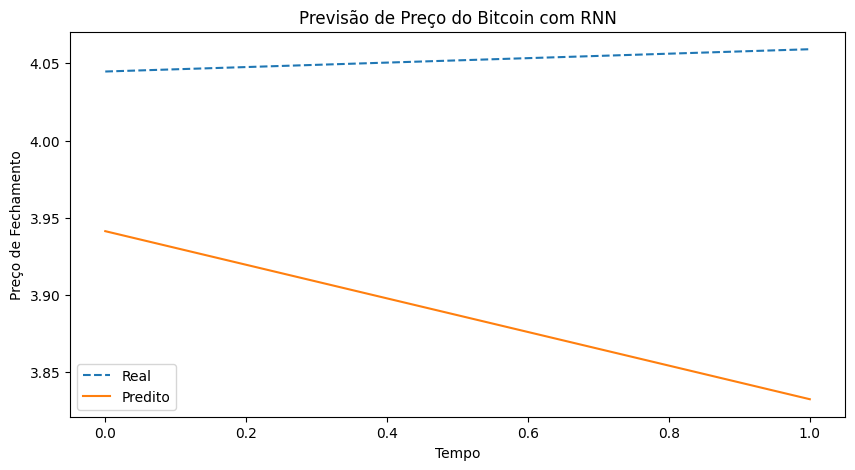

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real', linestyle='dashed')
plt.plot(y_pred, label='Predito')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.title('Previsão de Preço do Bitcoin com RNN')
plt.show()